Observation to Model comparison
- 

Observational datasets (so far)\
1997 field data collection\
Grundartangi data every 10 minutes going back to the 1970s (with sparser data as you go back)\

In [1]:
import subprocess
import os
import pandas as pd
import netCDF4
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
import copy
import xarray as xr
from datetime import datetime, timedelta 
from ocean_c_lab_tools import *
from celluloid import Camera 
import PyCO2SYS as csys
import seawater as sw
from roms_regrid import *

In [2]:
f='/expanse/lustre/projects/cos100/uheede/Iceland_observations/Grundartangi_01062012-30072012.xls'
grundartangi = pd.read_excel(f,decimal=',')
xls = pd.ExcelFile('/expanse/lustre/projects/cos100/uheede/Iceland_observations/cruise_1997.xls')
df1 = pd.read_excel(xls, 'Sheet1',decimal=',')
df2 = pd.read_excel(xls, 'Sheet2',decimal=',')
df1
#df1.drop_indexes('index')

,Station,Latitude(∞N),Longitude(∞E),mon/day/yr,hh:mm,Ship,Cruise,Bottom Depth[m],Depth,Temperature,Salinity,Fluor
0,100,64.3633,-21.5200,1997-02-06,11:42:00,D01-1997,Hval01,10,0.5,0.3263,32.0875,0.3688
1,100,64.3633,-21.5200,1997-02-06,11:42:00,D01-1997,Hval01,10,1.0,0.2596,33.0624,0.3733
2,100,64.3633,-21.5200,1997-02-06,11:42:00,D01-1997,Hval01,10,1.5,0.2925,33.4925,0.4875
3,100,64.3633,-21.5200,1997-02-06,11:42:00,D01-1997,Hval01,10,2.0,0.2311,32.7254,0.6217
4,100,64.3633,-21.5200,1997-02-06,11:42:00,D01-1997,Hval01,10,2.5,0.2286,32.6823,0.6661
...,...,...,...,...,...,...,...,...,...,...,...,...
3568,2202,64.2750,-21.9683,1997-11-11,06:33:00,D21-1997,Hval27,30,32.5,7.0250,34.3260,0.6823
3569,2202,64.2750,-21.9683,1997-11-11,06:33:00,D21-1997,Hval27,30,33.0,7.0412,34.3133,0.6748
3570,2202,64.2750,-21.9683,1997-11-11,06:33:00,D21-1997,Hval27,30,33.5,7.0465,34.3178,0.6878
3571,2202,64.2750,-21.9683,1997-11-11,06:33:00,D21-1997,Hval27,30,34.0,7.0509,34.3187,0.6761


In [4]:
obs=xr.Dataset.from_dataframe(df1)
obs=obs.set_index(index=['Depth','mon/day/yr','Bottom Depth[m]'])
obs=obs.unstack('index')
obs=obs.rename(name_dict={'Bottom Depth[m]':'ID','mon/day/yr':'time','Depth':'depth'})
obs['Temperature']=obs['Temperature'].where(obs.depth<obs['ID'])
obs['Salinity']=obs['Salinity'].where(obs.depth<obs['ID'])

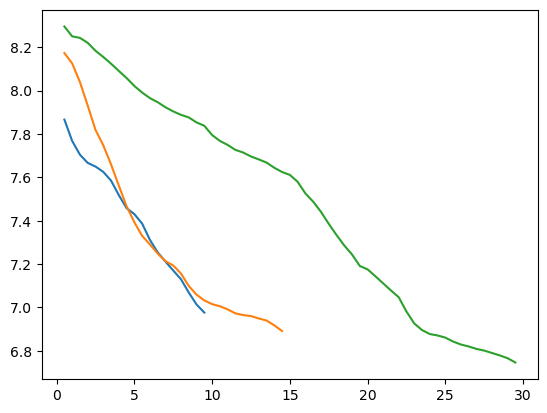

In [7]:
plt.plot(obs.depth,obs['Temperature'].isel(ID=0).sel(time=slice('05-06-1997','07-25-1997')).mean('time'))
plt.plot(obs.depth,obs['Temperature'].isel(ID=1).sel(time=slice('05-06-1997','07-25-1997')).mean('time'))
plt.plot(obs.depth,obs['Temperature'].isel(ID=2).sel(time=slice('05-06-1997','07-25-1997')).mean('time'))

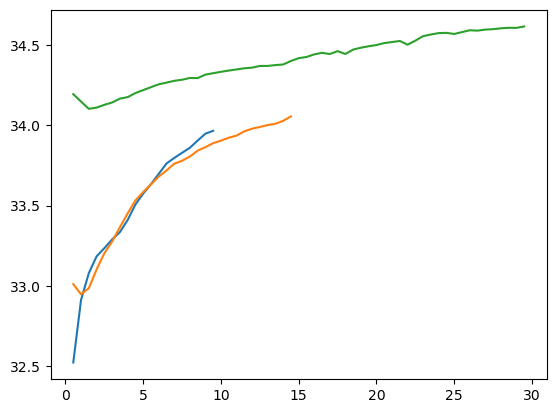

In [5]:
plt.plot(obs.depth,obs['Salinity'].isel(ID=0).sel(time=slice('05-06-1997','07-25-1997')).mean('time'))
plt.plot(obs.depth,obs['Salinity'].isel(ID=1).sel(time=slice('05-06-1997','07-25-1997')).mean('time'))
plt.plot(obs.depth,obs['Salinity'].isel(ID=2).sel(time=slice('05-06-1997','07-25-1997')).mean('time'))

In [6]:
x=xr.open_mfdataset('/expanse/lustre/projects/cos100/uheede/roms/run/Iceland3/Iceland3_rnd.20120516130000.nc', combine='nested', concat_dim=["time"])
grid=xr.open_mfdataset('/expanse/lustre/projects/cos100/uheede/Iceland3_grd.nc')

In [68]:
x1=xr.open_mfdataset('/expanse/lustre/projects/cos100/uheede/roms/run/Iceland3/z_Iceland3_rnd.201205*.nc', combine='nested', concat_dim=["time"])
x2=xr.open_mfdataset('/expanse/lustre/projects/cos100/uheede/roms/run/Iceland3/z_Iceland3_rnd.201206*.nc', combine='nested', concat_dim=["time"])
x3=xr.open_mfdataset('/expanse/lustre/projects/cos100/uheede/roms/run/Iceland3/z_Iceland3_rnd.201207*.nc', combine='nested', concat_dim=["time"])
x=xr.concat([x1,x2,x3],dim='time')
#x=xr.open_mfdataset('/expanse/lustre/projects/cos100/uheede/roms/run/Iceland3/Iceland3_rnd.20120516130000.nc', combine='nested', concat_dim=["time"])

x=x.mean('time')
grid=xr.open_mfdataset('/expanse/lustre/projects/cos100/uheede/Iceland3_grd.nc')
t=x['t']
s=x['s']


t=roms_regrid(grid,t)
s=roms_regrid(grid,s)
t=t.where(t != 0)
s=s.where(s != 0)

In [69]:
t.load()
#s.load()

<xarray.DataArray (depth: 34, lat: 722, lon: 722)>
array([[[     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        ...,
        [     nan, 9.929144, 9.911392, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan]],

       [[     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
...
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan]],

       [[     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        ...,
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan],
        [     nan,      nan,      nan, ...,      nan,      nan,
              nan]]], dtype=float32)
Coordinates:
  * depth    (depth) float32 -0.0 -1.0 -2.0 -3.0 ... -220.0 -240.0 -260.0 -280.0
  * lon      (lon) float64 337.2 337.2 337.2 337.2 ... 338.7 338.7 338.7 338.7
  * lat      (lat) float64 63.92 63.92 63.93 63.93 ... 64.57 64.57 64.57 64.57
Attributes:
    regrid_method:  bilinear

In [9]:
t1=t.sel(lat=64.2750, method='nearest').sel(lon=360-21.9683, method='nearest')
t2=t.sel(lat=64.39, method='nearest').sel(lon=360-21.52, method='nearest')
t3=t.sel(lat=64.365, method='nearest').sel(lon=360-21.52, method='nearest')

s1=s.sel(lat=64.2750, method='nearest').sel(lon=360-21.9683, method='nearest')
s2=s.sel(lat=64.39, method='nearest').sel(lon=360-21.52, method='nearest')
s3=s.sel(lat=64.365, method='nearest').sel(lon=360-21.52, method='nearest')


In [10]:
t3

<xarray.DataArray (depth: 34)>
array([8.254142 , 8.189458 , 8.090137 , 8.0126505, 7.9500246, 7.8466096,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan], dtype=float32)
Coordinates:
  * depth    (depth) float32 -0.0 -1.0 -2.0 -3.0 ... -220.0 -240.0 -260.0 -280.0
    lon      float64 338.5
    lat      float64 64.37
Attributes:
    regrid_method:  bilinear

Text(0.5, 0, 'Depth (m)')

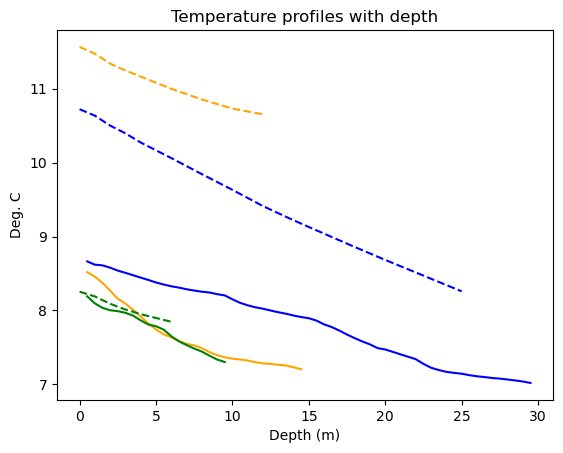

In [11]:
plt.plot(obs.depth,obs['Temperature'].isel(ID=2).sel(time=slice('05-05-1997','07-30-1997')).mean('time'),color='blue')
plt.plot(t1.depth*(-1),t1,color='blue',linestyle='--')

plt.plot(obs.depth,obs['Temperature'].isel(ID=1).sel(time=slice('05-05-1997','07-30-1997')).mean('time'),color='orange')
plt.plot(t2.depth*(-1),t2,color='orange',linestyle='--')

plt.plot(obs.depth,obs['Temperature'].isel(ID=0).sel(time=slice('05-05-1997','07-30-1997')).mean('time'),color='green')
plt.plot(t3.depth*(-1),t3,color='green',linestyle='--')
plt.title('Temperature profiles with depth')
plt.ylabel('Deg. C')
plt.xlabel('Depth (m)')

Text(0.5, 0, 'Depth (m)')

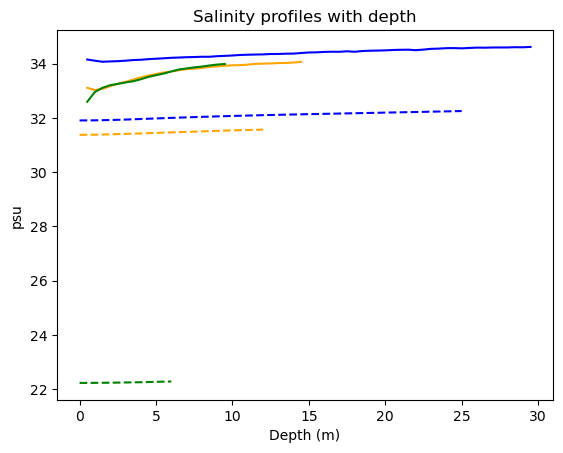

In [12]:
plt.plot(obs.depth,obs['Salinity'].isel(ID=2).sel(time=slice('05-05-1997','07-30-1997')).mean('time'),color='blue')
plt.plot(s1.depth*(-1),s1,color='blue',linestyle='--')

plt.plot(obs.depth,obs['Salinity'].isel(ID=1).sel(time=slice('05-05-1997','07-30-1997')).mean('time'),color='orange')
plt.plot(s2.depth*(-1),s2,color='orange',linestyle='--')

plt.plot(obs.depth,obs['Salinity'].isel(ID=0).sel(time=slice('05-05-1997','07-30-1997')).mean('time'),color='green')
plt.plot(s3.depth*(-1),s3,color='green',linestyle='--')

plt.title('Salinity profiles with depth')
plt.ylabel('psu')
plt.xlabel('Depth (m)')

In [5]:
grundartangi

,Timabil,Flodatafla (m),Sjavarhaed (m),Vindur (m/s),Hvida (m/s),Vindatt (deg),Loftthrystingur (hpa),Lofthiti (degC),Sjavarhiti (degC),Selta (PSU),Unnamed: 10
0,00:00 31.07.2012,1.07,-3,1,2,103,1012,12.5,232,0,
1,23:50 30.07.2012,1.00,-3,2,2,115,1012,12.5,232,0,
2,23:40 30.07.2012,0.93,-3,2,3,123,1012,12.4,232,0,
3,23:30 30.07.2012,0.88,-3,2,2,119,1012,12.5,232,0,
4,23:20 30.07.2012,0.84,-3,1,2,117,1012,12.7,232,0,
...,...,...,...,...,...,...,...,...,...,...,...
8636,00:40 01.06.2012,2.56,-3,7,9,234,1026,9.3,232,0,
8637,00:30 01.06.2012,2.45,-3,6,8,232,1026,9.3,232,0,
8638,00:20 01.06.2012,2.35,-3,7,9,233,1026,9.5,232,0,
8639,00:10 01.06.2012,2.24,-3,7,9,231,1026,9.7,232,0,


Text(0.5, 1.0, 'wind rose for summer winds 2012')

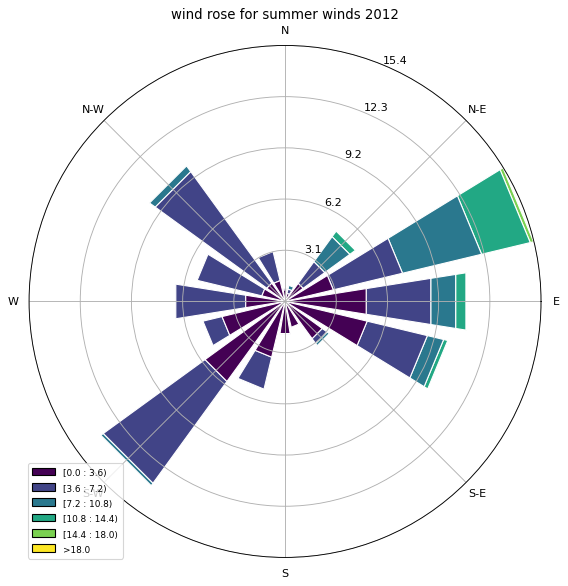

In [10]:
#plt.plot(grundartangi['Vindatt (deg)'])

from windrose import WindroseAxes
ax = WindroseAxes.from_ax()
ax.bar(grundartangi['Vindatt (deg)'], grundartangi['Vindur (m/s)'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
ax.set_title('wind rose for summer winds 2012')

Text(0.5, 0, 'time')

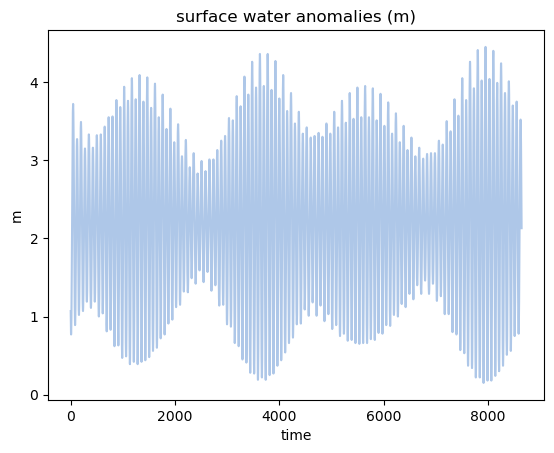

In [4]:
palette = plt.get_cmap('tab20')
plt.plot(grundartangi[' Flodatafla (m)'],color=palette(1))
plt.title('surface water anomalies (m)')
plt.ylabel('m')
plt.xlabel('time')


Text(0.5, 0, 'time')

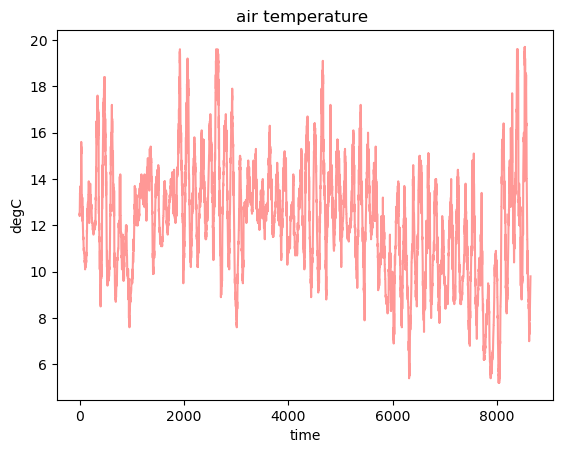

In [10]:
plt.plot(grundartangi['Lofthiti (degC)'],color=palette(7))
plt.title('air temperature ')
plt.ylabel('degC')
plt.xlabel('time')

In [6]:
import scipy
from scipy import stats as st
import xesmf as xe
st.mode(grundartangi['Vindatt (deg)'])
u=grundartangi['Vindur (m/s)']*np.cos(grundartangi['Vindatt (deg)'])
v=grundartangi['Vindur (m/s)']*np.sin(grundartangi['Vindatt (deg)'])

In [7]:
era=xr.open_mfdataset('/home/uheede/era5.[6-7]2017.nc', combine='nested', concat_dim=["time"])
u10_carra=xr.open_mfdataset('/expanse/lustre/projects/cos100/uheede/Arctic_datasets/u10_reanalysis.nc')
v10_carra=xr.open_mfdataset('/expanse/lustre/projects/cos100/uheede/Arctic_datasets/v10_reanalysis.nc')


In [8]:

u10_carra = u10_carra.rename({"longitude": "lon", "latitude": "lat"})
lon_min=(u10_carra.lon.min().values)
lon_max=(u10_carra.lon.max().values)
lon_step=((lon_max-lon_min)/len(u10_carra.x))

lat_min=(u10_carra.lat.min().values)
lat_max=(u10_carra.lat.max().values)
lat_step=((lat_max-lat_min)/len(u10_carra.y))

ds_out = xr.Dataset(
    {
        "lon": (["lon"], np.arange(lon_min, lon_max, lon_step), {"units": "degrees_north"}),
        "lat": (["lat"], np.arange(lat_min, lat_max, lat_step), {"units": "degrees_east"}),
    }
)

regridder = xe.Regridder(u10_carra, ds_out, "bilinear")
u10_rg=regridder(u10_carra['u10'])
v10_rg=regridder(v10_carra['v10'])

KeyboardInterrupt: 

In [10]:
u10=era['u10'].sel(latitude=64.3,method='nearest').sel(longitude=-21.7,method='nearest').load()
v10=era['v10'].sel(latitude=64.3,method='nearest').sel(longitude=-21.7,method='nearest').load()
#u10_cr=u10_rg.sel(lat=64.3,method='nearest').sel(lon=360-21.7,method='nearest').load()
#v10_cr=v10_rg.sel(lat=64.3,method='nearest').sel(lon=360-21.7,method='nearest').load()


In [11]:
#u10_rg.to_netcdf('/expanse/lustre/projects/cos100/uheede/Arctic_datasets/u10_reanalysis_regrid.nc')
#v10_rg.to_netcdf('/expanse/lustre/projects/cos100/uheede/Arctic_datasets/v10_reanalysis_regrid.nc')

u10_cr=u10_rg.sel(lat=64.3,method='nearest').sel(lon=360-21.7,method='nearest')
v10_cr=v10_rg.sel(lat=64.3,method='nearest').sel(lon=360-21.7,method='nearest')

NameError: name 'u10_rg' is not defined

PermissionError: [Errno 13] Permission denied: '/expanse/lustre/projects/cos100/uheede/Arctic_datasets/u10_reanalysis_regrid.nc'

In [12]:
u10_rg=xr.open_dataset('/expanse/lustre/projects/cos100/uheede/Arctic_datasets/u10_reanalysis_regrid.nc')
u10_cr=u10_rg.sel(lat=64.3,method='nearest').sel(lon=360-21.7,method='nearest')

v10_rg=xr.open_dataset('/expanse/lustre/projects/cos100/uheede/Arctic_datasets/v10_reanalysis_regrid.nc')
v10_cr=v10_rg.sel(lat=64.3,method='nearest').sel(lon=360-21.7,method='nearest')

In [41]:
forecast=xr.open_dataset('/expanse/lustre/projects/cos100/uheede/Arctic_datasets/arome_arctic_lagged_12_h_latest_2_5km_latest.nc')
forecast = forecast.rename({"longitude": "lon", "latitude": "lat"})

#forecast=forecast.assign_coords({"lon": (forecast.lon % 360)})

lon_min=(forecast.lon.min().values)
lon_max=(forecast.lon.max().values)
lon_step=((lon_max-lon_min)/len(forecast.x))

lat_min=(forecast.lat.min().values)
lat_max=(forecast.lat.max().values)
lat_step=((lat_max-lat_min)/len(forecast.y))

ds_out = xr.Dataset(
    {
        "lon": (["lon"], np.arange(lon_min, lon_max, lon_step), {"units": "degrees_north"}),
        "lat": (["lat"], np.arange(lat_min, lat_max, lat_step), {"units": "degrees_east"}),
    }
)

regridder = xe.Regridder(forecast, ds_out, "bilinear")



In [38]:
u10_rg_fc=regridder(forecast['x_wind_10m'].isel(ensemble_member=1).squeeze())
u10_rg_fc1=u10_rg_fc.sel(lat=64.3,method='nearest').sel(lon=360-21.7,method='nearest').squeeze()

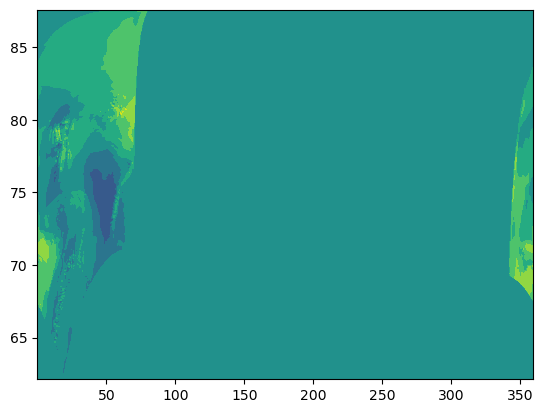

In [39]:
plt.contourf(u10_rg_fc.lon,u10_rg_fc.lat,u10_rg_fc.squeeze().isel(time=40))

In [42]:
forecast.lon

<xarray.DataArray 'lon' (y: 949, x: 739)>
array([[-17.956718, -17.894133, -17.831565, ...,  18.55296 ,  18.587438,
         18.621878],
       [-17.949161, -17.886511, -17.823877, ...,  18.584611,  18.619092,
         18.653536],
       [-17.941589, -17.878873, -17.816173, ...,  18.6163  ,  18.650784,
         18.68523 ],
       ...,
       [ 78.541333,  78.442812,  78.345966, ...,  68.697202,  68.695421,
         68.693644],
       [ 79.047574,  78.944895,  78.843955, ...,  68.766405,  68.764542,
         68.762684],
       [ 79.552032,  79.445239,  79.340249, ...,  68.835604,  68.83366 ,
         68.83172 ]])
Coordinates:
  * x        (x) float32 2.786e+05 2.811e+05 2.836e+05 ... 2.121e+06 2.124e+06
  * y        (y) float32 -8.98e+05 -8.955e+05 -8.93e+05 ... 1.47e+06 1.472e+06
    lon      (y, x) float64 -17.96 -17.89 -17.83 -17.77 ... 68.84 68.83 68.83
    lat      (y, x) float64 69.3 69.3 69.29 69.29 ... 71.18 71.15 71.13 71.11
Attributes:
    units:          degree_east
    long_name:      longitude
    standard_name:  longitude

Text(0.5, 0, '10 min intervals since June 1st 2012')

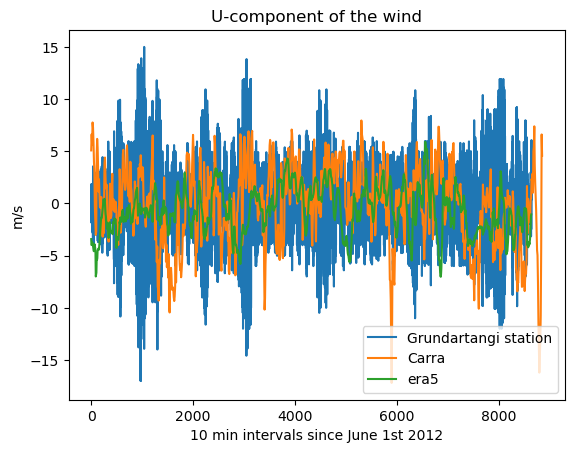

In [45]:
time1=np.arange(0,len(u))
time2=np.arange(0,len(u10)*6,6)
time3=np.arange(0,len(u10_cr['u10']*2/4)*6*3*2/4,6*3*2/4)
plt.plot(time1,u,label='Grundartangi station')

plt.plot(time3,u10_cr['u10'],label='Carra')
plt.plot(time2,u10,label='era5')
plt.title('U-component of the wind')
plt.legend()
plt.ylabel('m/s')
plt.xlabel('10 min intervals since June 1st 2012')

In [5]:
time1=np.arange(0,len(v))
time2=np.arange(0,len(v10)*6,6)
time3=np.arange(0,len(v10_cr['v10']*2/5)*6*3*2/5,6*3*2/5)
plt.plot(time1,u,label='Grundartangi station')

plt.plot(time3,v10_cr['v10'],label='Carra')
plt.plot(time2,v10,label='era5')
plt.title('V-component of the wind')
plt.legend()


NameError: name 'v' is not defined

In [2]:
woa=xr.open_mfdataset('/expanse/lustre/projects/cos100/uheede/WOA_data/*', combine='nested', concat_dim=["time"],decode_times=False)
#roms1=xr.open_mfdataset('/expanse/lustre/projects/cos100/uheede/roms/run/Iceland2_BGC/Iceland2_BGC_rnd.201205*130000.nc', combine='nested', concat_dim=["time"],decode_times=False)
#roms2=xr.open_mfdataset('/expanse/lustre/projects/cos100/uheede/roms/run/Iceland2_BGC/Iceland2_BGC_rnd.201206*130000.nc', combine='nested', concat_dim=["time"],decode_times=False)
#roms3=xr.open_mfdataset('/expanse/lustre/projects/cos100/uheede/roms/run/Iceland2_BGC/Iceland2_BGC_rnd.201207*130000.nc', combine='nested', concat_dim=["time"],decode_times=False)
grid=xr.open_mfdataset('/expanse/lustre/projects/cos100/uheede/roms/work/Iceland2_BGC/INPUT/Iceland2_grd.nc')
filelist=os.listdir('/expanse/lustre/projects/cos100/uheede/roms/run/Iceland2_BGC/HOLD_RND')


roms1=xr.open_mfdataset('/expanse/lustre/projects/cos100/uheede/roms/run/Iceland2_BGC/HOLD_RND/'+str(filelist[0]), combine='nested', concat_dim=["time"],decode_times=False)
t1=roms1['t']
t1=roms_regrid(grid,t1)
t=t1.load()
t.to_netcdf('/expanse/lustre/projects/cos100/uheede/roms/run/Iceland2_BGC/HOLD_RND/'+str(filelist[0])+'_t_regrid')

#for i in np.arange(1,len(filelist)):
#    roms1=xr.open_mfdataset('/expanse/lustre/projects/cos100/uheede/roms/run/Iceland2_BGC/HOLD_RND/'+str(filelist[0]), combine='nested', concat_dim=["time"],decode_times=False)
#    t1=roms1['t']
#    t1=roms_regrid(grid,t1)
#    t1=t1.load()
#    t1.to_netcdf('/expanse/lustre/projects/cos100/uheede/roms/run/Iceland2_BGC/HOLD_RND/'+str(filelist[0])+'_t_regrid')
#    t=xr.concat([t,t1],dim='time')

#t1=roms_regrid(grid,t1)
#t2=roms_regrid(grid,t2)
#t3=roms_regrid(grid,t3)


/home/uheede/.conda/envs/xarray_new/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 25
  intermediate = blockwise(


KeyboardInterrupt: 

In [10]:
range(1,len(filelist))

range(1, 82)

In [ ]:
t1=t1.load()

In [126]:
#plot_obs=woa['t_an'].sel(depth=0).mean('time').sel(lat=slice(60,75)).sel(lon=slice(-25,-15))
plot_obs=woa['t_an'].sel(depth=0).mean('time').sel(lat=slice(63.5,65)).sel(lon=slice(-23-5,-20))
plot_model=t.sel(depth=0)

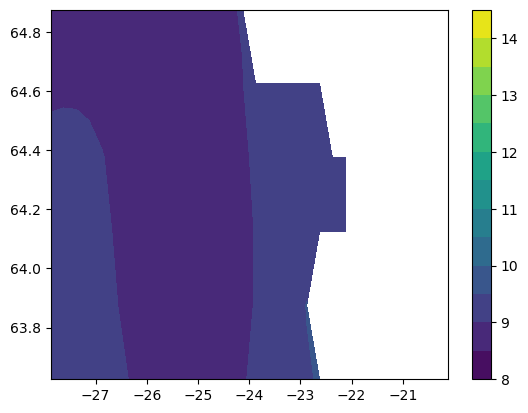

In [127]:
levels=np.arange(8,15,0.5)
cf1=plt.contourf(plot_obs.lon,plot_obs.lat,plot_obs,levels)
cp1=plt.colorbar(cf1)

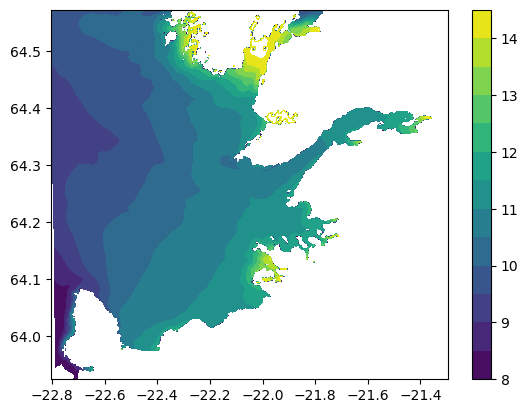

In [128]:
levels=np.arange(8,15,0.5)

cf1=plt.contourf(plot_model.lon-360,plot_model.lat,plot_model,levels)
cp1=plt.colorbar(cf1)

In [113]:
#plot_obs=woa['t_an'].sel(depth=0).mean('time').sel(lat=slice(60,75)).sel(lon=slice(-25,-15))
plot_obs=woa['t_an'].mean('time').sel(lat=63,method='nearest').sel(lon=-24,method='nearest')
plot_model=t.sel(lat=63, lon=-24)

KeyError: "not all values found in index 'lat'. Try setting the `method` keyword argument (example: method='nearest')."